# Fine-Tuning for classification

We will fine tune our model to classify instances. In this case, spam and not spam

Fine tuning is not required on all layers, it is in fact only applied on the last layers.

**Types**

There are two fine tuning language models, instruction fine-tuning and classification fine-tuning.

The first trains the model on a set of tasks based on specific instructions. For example, if we want to translate a text, we would provide as an input the instruction "Translate to Spanish".

The latter, the model is trained to recognize a specific set of labels. Its output will be one of the desired labels, nothing else.

While instruction fine-tuning is more versatile, it demands larger datasets and greater
computational resources to develop models proficient in various tasks. In contrast,
classification fine-tuning requires less data and compute power, but its use is confined to the specific classes on which the model has been trained.

Classification fine-tuning is ideal for projects requiring precise categorization of data into predefined classes, such as sentiment analysis or spam detection. This is the reason why we will use it now.

**Steps**

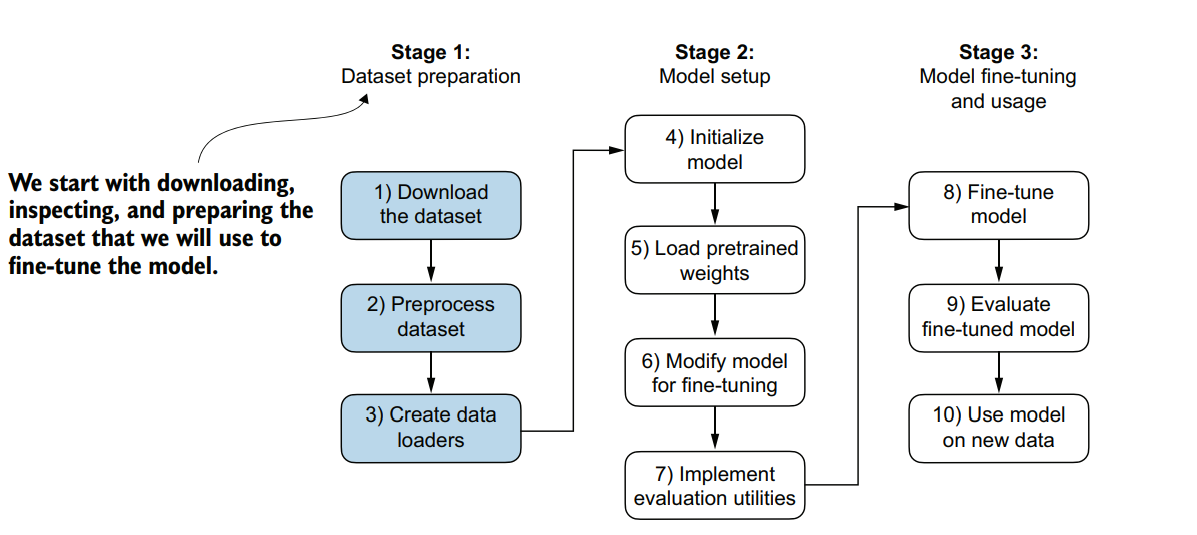

In [2]:
# Downloading the dataset
import urllib.request
import zipfile
import os
from pathlib import Path


url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
 url, zip_path, extracted_path, data_file_path):
 if data_file_path.exists():
    print(f"{data_file_path} already exists. Skipping download "
 "and extraction."
 )
    return

 # Downloads the file
 with urllib.request.urlopen(url) as response:
    with open(zip_path, "wb") as out_file:
        out_file.write(response.read())

 # Unzips the file
 with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_path)

 # Adds tsv
 original_file_path = Path(extracted_path) / "SMSSpamCollection"
 os.rename(original_file_path, data_file_path)
 print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
# Loading the data
import pandas as pd
df = pd.read_csv(
 data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df

print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


As there is a much higher number for non spam data, we need to provide a balance dataset, to not affect our classification. Moreover, this will make it simpler when training our .

To achieve this, we will use undersampling, which consists on reducing the size of the majority class to match the size of the minority one.

In [4]:
def create_balanced_dataset(df):
 """Balances the dataset using undersampling"""
 # Number of spam messages
 num_spam = df[df["Label"] == "spam"].shape[0]
 # Selects the same number of ham instances as spam
 ham_subset = df[df["Label"] == "ham"].sample(
 num_spam, random_state=123
 )
 # Combines both into a new dataset
 balanced_df = pd.concat([
 ham_subset, df[df["Label"] == "spam"]
 ])
 # Returns the balanced dataset
 return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

# Moreover, this labels are strings, thus we will apply encoding which will make them easier to deal with.
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})



Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
# Splitting the dataset into 70% training, 10% validation and 20% testing

# Validation set is used in training as well, it helps with adjusting hyperparameters, its like studying with past years exams before 
# the final exam

def random_split(df, train_frac: float, validation_frac: float):
 """Function for splitting data into different sets
 df: dataframe to split
 train_frac: Split dedicated to training
 validation_frac: Split dedicated to validation"""

 # Shuffles the dataset
 df = df.sample(
 frac=1, random_state=123
 ).reset_index(drop=True)

 # How many instances should be dedicated into the different sets
 train_end = int(len(df) * train_frac)
 validation_end = train_end + int(len(df) * validation_frac)

 # Separates dataset in three parts
 train_df = df[:train_end]
 validation_df = df[train_end:validation_end]
 test_df = df[validation_end:]
 
 # Returns the three splits
 return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(
 balanced_df, 0.7,0.1)

In [6]:
# Saving the datasets to CSV
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

**Data Loaders**

As we are dealing with different batches of data to before, we have to make some changes. 

We have to use our current input to classify into both spam or not spam.

As each chunk is an individual training instance, we have to fix these instances to an specific length. The batches in the training data must be of the same size to work correctly.

We have two possibilities, either truncating all messages to the length of the smallest one, or padding all messages to the length of the the longest one.

The first one is clearly more feasible in terms of computation, however we may lose lots of valuable information, which is why we will use the second approach

We will use the endoftoken token to padd elements, its TokenId is 50256

In [7]:
# Creating the Dataset class
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
 def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
    # Initializing the data
    self.data = pd.read_csv(csv_file)

    # Encoding the texts
    self.encoded_texts = [
    tokenizer.encode(text) for text in self.data["Text"]
    ]

    # Finds the largest length text
    if max_length is None:
        self.max_length = self._longest_encoded_length()
    else:
        self.max_length = max_length

        # Truncates length if they are larger
        self.encoded_texts = [
        encoded_text[:self.max_length]
        for encoded_text in self.encoded_texts
        ]

    # Padds shorter texts
    self.encoded_texts = [
    encoded_text + [pad_token_id] *
    (self.max_length - len(encoded_text))
    for encoded_text in self.encoded_texts
    ]

    # Retrieves instance by its index
 def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
        torch.tensor(encoded, dtype=torch.long),
        torch.tensor(label, dtype=torch.long)
        )
    
    # Returns length of data
 def __len__(self):
        return len(self.data)
    
    # Finds longest text
 def _longest_encoded_length(self):
        # Initializes storer
        max_length = 0
        # Loops through texts
        for encoded_text in self.encoded_texts:
            # Obtains length
            encoded_length = len(encoded_text)
            # Compares lenghts
            if encoded_length > max_length:
                # Stores maximal length
                max_length = encoded_length

        # Return largest value
        return max_length


In [8]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
 csv_file="train.csv",
 max_length=None,
 tokenizer=tokenizer
)

val_dataset = SpamDataset(
 csv_file="validation.csv",
 max_length=train_dataset.max_length,
 tokenizer=tokenizer
)
test_dataset = SpamDataset(
 csv_file="test.csv",
 max_length=train_dataset.max_length,
 tokenizer=tokenizer
)

print("Largest text:",train_dataset.max_length)
# We have a maximum context length of 1024, now it is not needed, but for potential longer texts max_length = 1024 should be considered.

Largest text: 120


**DataLoaders**

We will use batches of size 8, with each training instance consisting of 120 tokens and a predicted label of either 0 or 1 depending on the chosen class.

No specific reason for this, we can vary the batch size, however, this number will be good for our computer operations

In [9]:
from torch.utils.data import DataLoader

num_workers = 0 # No parallel processing
batch_size = 8
torch.manual_seed(123) 

# Training DataLoader
train_loader = DataLoader(
 dataset=train_dataset,
 batch_size=batch_size,
 shuffle=True,
 num_workers=num_workers,
 drop_last=True,
)

# Validation DataLoader
val_loader = DataLoader(
 dataset=val_dataset,
 batch_size=batch_size,
 num_workers=num_workers,
 drop_last=False,
)

# Testing DataLoader
test_loader = DataLoader(
 dataset=test_dataset,
 batch_size=batch_size,
 num_workers=num_workers,
 drop_last=False,
)

# Ensuring our DataLoaders are correct
for input_batch, target_batch in train_loader:
 pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
19 validation batches
38 test batches


**Initializing the model**

In [11]:
    # Using the same model as in our previous chapters
    CHOOSE_MODEL = "gpt2-small (124M)" 
    INPUT_PROMPT = "Every effort moves" 

    BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024, # The longest sequence the model can support
    "drop_rate": 0.0,
    "qkv_bias": True}
    

    model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
    }

    BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [12]:
# Loading the pretrained GPT model
from gpt_download import download_and_load_gpt2
from chapter05 import load_weights_into_gpt
from chapter04 import GPTModel

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
 model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

After loading the model weights we now use the text generation functions.

In [ ]:
from chapter04 import generate_text_simple
from chapter05 import text_to_token_ids, token_ids_to_text

# Text sample
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(text_1, tokenizer),
 max_new_tokens=15,
 context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))
# We see our model creates coherent text

Every effort moves you forward.

The first step is to understand the importance of your work


**Classification Head**

We have to modify our output layer. This is because of having a vocabulary of 50,257 words, the output is either 0 or 1.  

In [16]:
# Freezing our current model
for param in model.parameters():
 param.requires_grad = False

# Classification layer
torch.manual_seed(123)
num_classes = 2 # Spam or not spam
# Last linear layer
model.out_head = torch.nn.Linear(
 in_features=BASE_CONFIG["emb_dim"],
 out_features=num_classes
)

# It already has requires_grad = T <- Trainable
# We will also fine tune the last transformer block and layernorm

for param in model.trf_blocks[-1].parameters():
 param.requires_grad = True
for param in model.final_norm.parameters():
 param.requires_grad = True


In [ ]:
# Testing our current model
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) 

with torch.no_grad():
 outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

# In our previous model, the outputs dimensions would be given by [1,4, 50257]

# Due to our causal attention mask, where we had the matrix full of 0s above as we are only paying attention to the current input,
# in the output we are dealing with now, we only care about the last row. As the last token takes all of them into account
print("Last output token:", outputs[:, -1, :])

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])
Last output token: tensor([[-3.5983,  3.9902]])


**Calculating loss and accuracy**

We have to compute the last row probabilities, where we will assign the instance to the class with the largest probability.

In [ ]:
# Softmax (not strictly necessary)
probas = torch.softmax(outputs[:, -1, :], dim=-1)
# Output label
label = torch.argmax(probas)
print("Class label:", label.item())

Computing accuracy

Accuracy measures the number of correctly classified instances.

In [19]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
 model.eval() # No training
 # Initialize counters
 correct_predictions, num_examples = 0, 0

 # Number of batches
 if num_batches is None:
    num_batches = len(data_loader)
 else:
    num_batches = min(num_batches, len(data_loader))

 # Iterating loader
 for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        with torch.no_grad():
            logits = model(input_batch)[:, -1, :] # Outputs per token
            predicted_labels = torch.argmax(logits, dim=-1) # Selects class with highest score
            num_examples += predicted_labels.shape[0] # Adds the number of examples to the total
            correct_predictions += (
            (predicted_labels == target_batch).sum().item()
            ) # Adds one correct prediction if the value is the same
    else:
        break
 # Returns accuracy
 return correct_predictions / num_examples

In [20]:
# Obtaining accuracy for 10 batches of our previous datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
 train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
 val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
 test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


Values are less than 50, thus meaning the model is doing worse than random prediction. Something which suggests we have to apply fine tuning

Before, we will provide the loss functions, where we will provide slight changes respect to those previously commented in above chapters.

In [23]:
# Loss for a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
 input_batch = input_batch.to(device)
 target_batch = target_batch.to(device)
 logits = model(input_batch)[:, -1, :] # Last input token, classifying a sentence, not each token
 loss = torch.nn.functional.cross_entropy(logits, target_batch)
 return loss

# Loss for all batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
 # Initialize loss 
 total_loss = 0.

 # Number of batches
 if len(data_loader) == 0:
    return float("nan")
 elif num_batches is None:
    num_batches = len(data_loader)
 else:
    num_batches = min(num_batches, len(data_loader))
 
 # Iterating calculating loss for each batch
 for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
            input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
 # Returns average loss
 return total_loss / num_batches

In [24]:
# Calculating the loss for each set
with torch.no_grad():
 train_loss = calc_loss_loader(
 train_loader, model, device, num_batches=5
 )
 val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
 test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")


Training loss: 3.211
Validation loss: 2.583
Test loss: 2.322


**Fine-tuning the model**

The training loop will be the same expcept for the replacement of the text generator for the accuracy calcualtor.

In [25]:
def train_classifier_simple(
 model, train_loader, val_loader, optimizer, device,
 num_epochs, eval_freq, eval_iter):
 # Initialize empty lists
 train_losses, val_losses, train_accs, val_accs = [], [], [], []
 examples_seen, global_step = 0, -1

 for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Resets gradients
        loss = calc_loss_batch( # Calculates loss
        input_batch, target_batch, model, device
        )
        loss.backward() # Backpropagation
        optimizer.step() # Update weights
        # Update parameters
        examples_seen += input_batch.shape[0]
        global_step += 1

        # Optional evaluation step
        if global_step % eval_freq == 0:
            train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Ep {epoch+1} (Step {global_step:06d}): "
            f"Train loss {train_loss:.3f}, "
            f"Val loss {val_loss:.3f}"
            )

 # Accuracy for each batch
 train_accuracy = calc_accuracy_loader(
 train_loader, model, device, num_batches=eval_iter
 )
 val_accuracy = calc_accuracy_loader(
 val_loader, model, device, num_batches=eval_iter
 )
 print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
 print(f"Validation accuracy: {val_accuracy*100:.2f}%")
 # Store accuracies
 train_accs.append(train_accuracy)
 val_accs.append(val_accuracy)

 # Returns losses and accuracies
 return train_losses, val_losses, train_accs, val_accs, examples_seen

# Evaluating the model
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
 model.eval()
 with torch.no_grad():
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=eval_iter
    )
    val_loss = calc_loss_loader(
    val_loader, model, device, num_batches=eval_iter
    )
 model.train()
 return train_loss, val_loss

In [26]:
# Initalizing the optimizer and running our model
torch.manual_seed(123)
# AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
# Training loop
train_losses, val_losses, train_accs, val_accs, examples_seen = \
 train_classifier_simple(
 model, train_loader, val_loader, optimizer, device,
 num_epochs=num_epochs, eval_freq=50,
 eval_iter=5
 )

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Ep 2 (Step 000150): Train loss 0.501, Val loss 0.456
Ep 2 (Step 000200): Train loss 0.447, Val loss 0.377
Ep 2 (Step 000250): Train loss 0.410, Val loss 0.367
Ep 3 (Step 000300): Train loss 0.317, Val loss 0.315
Ep 3 (Step 000350): Train loss 0.364, Val loss 0.300
Ep 4 (Step 000400): Train loss 0.379, Val loss 0.182
Ep 4 (Step 000450): Train loss 0.100, Val loss 0.121
Ep 4 (Step 000500): Train loss 0.074, Val loss 0.117
Ep 5 (Step 000550): Train loss 0.043, Val loss 0.086
Ep 5 (Step 000600): Train loss 0.137, Val loss 0.093
Training accuracy: 97.50% | Validation accuracy: 97.50%


Choosing the number of epochs
Earlier, when we initiated the training, we set the number of epochs to five. The number of epochs depends on the dataset and the task’s difficulty, and there is no universal solution or recommendation, although an epoch number of five is usually a
good starting point. If the model overfits after the first few epochs as a loss plot (see
figure 6.16), you may need to reduce the number of epochs. Conversely, if the trendline suggests that the validation loss could improve with further training, you should
increase the number of epochs. In this concrete case, five epochs is a reasonable
number as there are no signs of early overfitting, and the validation loss is close to 0.

Plotting validation and training losses with matplotlib.

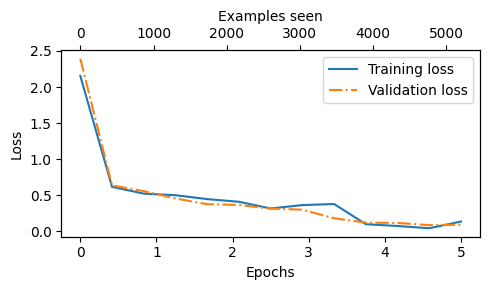

In [27]:
import matplotlib.pyplot as plt
def plot_values(
 epochs_seen, examples_seen, train_values, val_values,
 label="loss"):
 fig, ax1 = plt.subplots(figsize=(5, 3))

 ax1.plot(epochs_seen, train_values, label=f"Training {label}")
 ax1.plot(
 epochs_seen, val_values, linestyle="-.",
 label=f"Validation {label}"
 )
 ax1.set_xlabel("Epochs")
 ax1.set_ylabel(label.capitalize())
 ax1.legend()

 ax2 = ax1.twiny()
 ax2.plot(examples_seen, train_values, alpha=0)
 ax2.set_xlabel("Examples seen")
 fig.tight_layout()
 plt.savefig(f"{label}-plot.pdf")
 plt.show()
 
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

The model seems to be working well, as there is a clear improvement as well as a good behavior with unseen data.

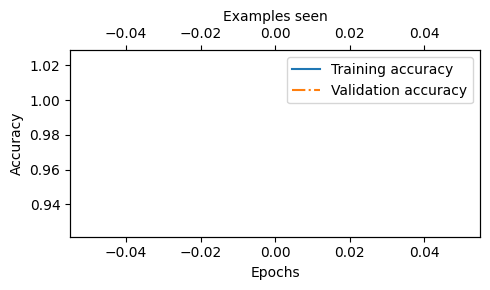

KeyboardInterrupt: 

In [34]:
# Plotting the accuracies
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(
 epochs_tensor, examples_seen_tensor, train_accs, val_accs,
 label="accuracy"
)

# Obtaning the accuracies for each set
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

# The gap between testing and validation could be due to unseen data where we do not know how the model will behave
# However, this can be modified with changing the dropout rate or weight decay

**Spam classifier**

In [29]:
# Using the model to classify spam
def classify_review(
 text, model, tokenizer, device, max_length=None,
 pad_token_id=50256):

 model.eval()
 # Encode text
 input_ids = tokenizer.encode(text)

 # Context length
 supported_context_length = model.pos_emb.weight.shape[1]

 # Truncates sequences if too long
 input_ids = input_ids[:min(
 max_length, supported_context_length
 )]

 # Pads sequences if too short
 input_ids += [pad_token_id] * (max_length - len(input_ids))

 input_tensor = torch.tensor(
 input_ids, device=device
 ).unsqueeze(0)

 with torch.no_grad(): # Model inference
    logits = model(input_tensor)[:, -1, :] # Output last row
 predicted_label = torch.argmax(logits, dim=-1).item() # Predicted class

 # Return desired class
 return "spam" if predicted_label == 1 else "not spam"

In [30]:
# Testing our classifier
text_1 = (
 "You are a winner you have been specially"
 " selected to receive $1000 cash or a $2000 award."
)
print("Text 1 is classified as:",classify_review(
 text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

text_2 = (
 "Hey, just wanted to check if we're still on"
 " for dinner tonight? Let me know!"
)
print("Text 2 is classified as:", classify_review(
 text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

Text 1 is classified as: spam
Text 2 is classified as: not spam


In [33]:
# Saving our current model
torch.save(model.state_dict(), "review_classifier.pth")

# Loading the model
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

**Summary**

 There are different strategies for fine-tuning LLMs, including classification
fine-tuning and instruction fine-tuning.

 Classification fine-tuning involves replacing the output layer of an LLM via a
small classification layer.

 In the case of classifying text messages as “spam” or “not spam,” the new classification layer consists of only two output nodes. Previously, we used the number
of output nodes equal to the number of unique tokens in the vocabulary
(i.e., 50,256).

 Instead of predicting the next token in the text as in pretraining, classification
fine-tuning trains the model to output a correct class label—for example,
“spam” or “not spam.”

 The model input for fine-tuning is text converted into token IDs, similar to
pretraining.

 Before fine-tuning an LLM, we load the pretrained model as a base model.

 Evaluating a classification model involves calculating the classification accuracy
(the fraction or percentage of correct predictions).

 Fine-tuning a classification model uses the same cross entropy loss function as
when pretraining the LLM.